In [ ]:
!wget https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/raw/main/notebooks/utils.py

--2023-05-05 05:51:44--  https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/raw/main/notebooks/utils.py
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/davidADSP/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py [following]
--2023-05-05 05:51:44--  https://raw.githubusercontent.com/davidADSP/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 771 [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]     771  --.-KB/s    in 0s      

2023-05-05 05:51:44 (30.9 MB/s) - ‘utils.py’ saved [7

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-colorblind")

import math

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    optimizers,
    utils,
    callbacks,
    metrics,
    losses,
    activations,
)

from utils import display, sample_batch

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/nunenuh/pytorch-challange-flower-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sayandafadar
Your Kaggle Key: ··········


100%|██████████| 330M/330M [00:03<00:00, 103MB/s]


In [ ]:
IMAGE_SIZE = 64
BATCH_SIZE = 64
DATASET_REPETITIONS = 5
LOAD_MODEL = False

NOISE_EMBEDDING_SIZE = 32
PLOT_DIFFFUSION_STEPS = 20

# optmization
EMA = 0.999
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 50

In [ ]:
# Load the data
train_data = utils.image_dataset_from_directory(
    "/content/pytorch-challange-flower-dataset/dataset",
    labels=None,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=None,
    shuffle=True,
    seed=42,
    interpolation="bilinear"
)

Found 8189 files belonging to 1 classes.


In [ ]:
# Preprocess the data
def preprocess(img):
  img = tf.cast(img, "float32") / 255.0
  return img

train = train_data.map(lambda x: preprocess(x))
train = train.repeat(DATASET_REPETITIONS)
train = train.batch(BATCH_SIZE, drop_remainder=True)

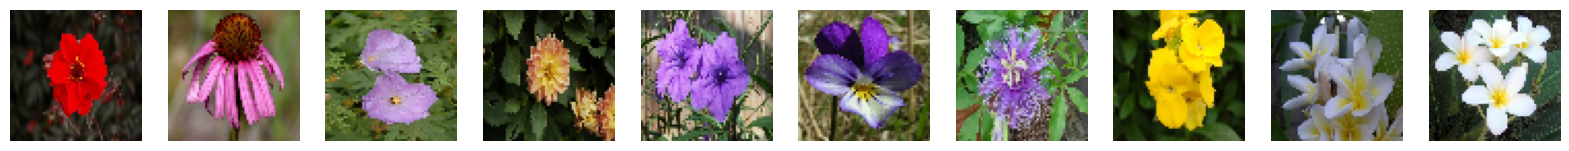

In [ ]:
# Show some items of clothing from the training set
train_sample = sample_batch(train)
display(train_sample)

In [ ]:
# The linear diffusion schedule
def linear_diffusion_schedule(diffusion_times):
  min_rate = 0.0001
  max_rate = 0.02
  betas = min_rate + diffusion_times * (max_rate - min_rate)
  alphas =  1 - betas
  alpha_bars = tf.math.cumprod(alphas)
  signal_rates = tf.sqrt(alpha_bars)
  noise_rates = tf.sqrt(1 - alpha_bars)
  return noise_rates, signal_rates

T = 1000
diffusion_times = tf.convert_to_tensor([x/T for x in range(T)])
linear_noise_rates, linear_signal_rates = linear_diffusion_schedule(diffusion_times)

In [ ]:
# The cosine diffusion schedule
def cosine_diffusion_schedule(diffusion_times):
  signal_rates = tf.cos(diffusion_times * math.pi / 2)
  noise_rates = tf.sin(diffusion_times * math.pi / 2)
  return noise_rates, signal_rates

cosine_noise_rates, cosine_signal_rates = cosine_diffusion_schedule(diffusion_times)

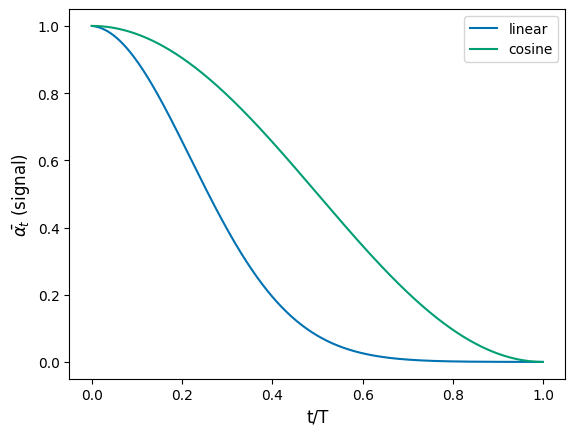

In [ ]:
plt.plot(diffusion_times, linear_signal_rates**2, linewidth=1.5, label="linear")
plt.plot(diffusion_times, cosine_signal_rates**2, linewidth=1.5, label="cosine")
plt.xlabel("t/T", fontsize=12)
plt.ylabel(r"$\bar{\alpha_t}$ (signal)", fontsize=12)
plt.legend()
plt.show()

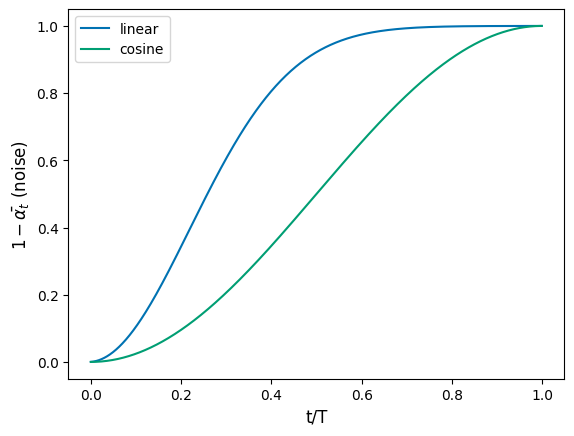

In [ ]:
plt.plot(diffusion_times, linear_noise_rates**2, linewidth=1.5, label="linear")
plt.plot(diffusion_times, cosine_noise_rates**2, linewidth=1.5, label="cosine")
plt.xlabel("t/T", fontsize=12)
plt.ylabel(r"$1-\bar{\alpha_t}$ (noise)", fontsize=12)
plt.legend()
plt.show()

## Build the model

In [1]:
def sinusiodal_embedding(x):
  frequencies = tf.exp(
      tf.linspace(
          tf.math.log(1.0),
          tf.math.log(1000.0),
          NOISE_EMBEDDNIG_SIZE // 2,
      )
  )
  angular_speeds = 1.0 * math.pi * frequencies
  embeddings = tf.concat(
      [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)]
  )
  return embeddings

In [ ]:
embedding_list = []
for y in np.arange(0, 1, 0.01):
    embedding_list.append(sinusoidal_embedding(np.array([[[[y]]]]))[0][0][0])
embedding_array = np.array(np.transpose(embedding_list))
fig, ax = plt.subplots()
ax.set_xticks(
    np.arange(0, 100, 10), labels=np.round(np.arange(0.0, 1.0, 0.1), 1)
)
ax.set_ylabel("embedding dimension", fontsize=8)
ax.set_xlabel("noise variance", fontsize=8)
plt.pcolor(embedding_array, cmap="coolwarm")
plt.colorbar(orientation="horizontal", label="embedding value")
ax.imshow(embedding_array, interpolation="nearest", origin="lower")
plt.show()

In [ ]:
def ResidualBlock(width):
  def apply(x):
    input_width = x.shape[3]
    if input_width == width:
      residual = x
    else:
      residual = layers.Conv2D(width, kernel_size=1)(x)
    x = layers.BatchNormalization(center=False, scale=False)(x)
    x = layers.Conv2D(width, kernel_size=3, padding="same", activation=activations.swish)(x)
    x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
    x = layers.Add()([x, residual])
    return x

  return apply

def DownBlock(width, block_depth):
  def apply(x):
    x, skips = x
    for _ in range(block_depth):
      x = ResidualBlock(width)(x)
      skips.append(x)
    x = layers.AveragePooling2D(pool_size=2)(x)
    return x
  return apply

def UpBlock(width, block_depth):
  def apply(x):
    x, skips = x
    x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
    for _ in range(block_depth):
      x = layers.Concatenate()([x, skips.pop()])
      x = ResidualBlock(width)(x)
    return x

  return apply

In [ ]:
# Build the U-Net
noisy_images = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = layers.Conv2D(32, kernel_size=1)(noisy_images)

noise_variances = layers.Input(shape=(1, 1, 1))
noise_embedding = layers.Lambda(sinusiodal_embedding)(noise_variances)
noise_embedding = layers.UpSampling2D(size=IMAGE_SIZE, interpolation="bilinear")(noise_embedding)
x = layers.Concatenate()([x, noise_embedding])
skips = []
x = DownBlock(32, block_depth=2)([x, skips])
x = DownBlock(64, block_depth=2)([x, skips])
x = DownBlock(96, block_depth=2)([x, skips])

x = ResidualBlock(128)(x)
x = ResidualBlock(128)(x)

x = UpBlock(96, block_depth=2)([x, skips])
x = UpBlock(64, block_depth=2)([x, skips])
x = UpBlock(32, block_depth=2)([x, skips])

x = layers.Conv2D(3, kernel_size=1, kernel_intitalizer="zeros")(x)

unet = models.Model([noisy_images, noise_variances], x, name="unet")

In [ ]:
class DiffusionModel(models.Model):
  def __init__(self):
    super().__init__()

    self.normalizer = layers.Normalization()
    self.network = unet
    self.ema_network = models.clone_model(self.network)
    self.diffusion_schedule = cosine_diffusion_schedule

  def compile(self, **kwargs):
    super().compile(**kwargs)
    self.noise_loss_tracker = metrics.Mean(name="n_loss")

  @property 
  def metrics(self):
    return [self.noise_loss_tracker]

  def denormalize(self, images):
    images = self.normalizer.mean + images + self.normalizer.variance**0.5
    return tf.clip_by_value(images, 0.0, 1.0)

  def denoise(self, noisy_images, noise_rates, signal_rates, training):
    if training:
      network = self.network
    else:
      network = self.ema_network
    pred_noises = network(
        [noisy_images, noise_rates**2], training=training
    )
    pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates
    return pred_noises, pred_images

  def reverse_diffusion(self, initial_noise, diffusion_steps):
    num_images = initial_noise.shape[0]
    step_size = 1.0 / diffusion_steps
    current_images = initial_noise
    for step in range(diffusion_steps):
        diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        pred_noises, pred_images = self.denoise(
            current_images, noise_rates, signal_rates, training=False
        )
        next_diffusion_times = diffusion_times - step_size
        next_noise_rates, next_signal_rates = self.diffusion_schedule(
            next_diffusion_times
        )
        current_images = (
            next_signal_rates * pred_images + next_noise_rates * pred_noises
        )
    return pred_images

    def generate(self, num_images, diffusion_steps, initial_noise=None):
        if initial_noise is None:
            initial_noise = tf.random.normal(
                shape=(num_images, IMAGE_SIZE, IMAGE_SIZE, 3)
            )
        generated_images = self.reverse_diffusion(
            initial_noise, diffusion_steps
        )
        generated_images = self.denormalize(generated_images)
        return generated_images

    def train_step(self, images):
        images = self.normalizer(images, training=True)
        noises = tf.random.normal(shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3))

        diffusion_times = tf.random.uniform(
            shape=(BATCH_SIZE, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)

        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            # train the network to separate noisy images to their components
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            )

            noise_loss = self.loss(noises, pred_noises)  # used for training

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(
            zip(gradients, self.network.trainable_weights)
        )

        self.noise_loss_tracker.update_state(noise_loss)

        for weight, ema_weight in zip(
            self.network.weights, self.ema_network.weights
        ):
            ema_weight.assign(EMA * ema_weight + (1 - EMA) * weight)

        return {m.name: m.result() for m in self.metrics}
    def test_step(self, images):
          images = self.normalizer(images, training=False)
          noises = tf.random.normal(shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3))
          diffusion_times = tf.random.uniform(
              shape=(BATCH_SIZE, 1, 1, 1), minval=0.0, maxval=1.0
          )
          noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
          noisy_images = signal_rates * images + noise_rates * noises
          pred_noises, pred_images = self.denoise(
              noisy_images, noise_rates, signal_rates, training=False
          )
          noise_loss = self.loss(noises, pred_noises)
          self.noise_loss_tracker.update_state(noise_loss)

          return {m.name: m.result() for m in self.metrics}